# Polygon to pois for other pois

This notebook uses the code from __Notebook 03d_polygon_to_pois_permanentresidences__ and __Notebook 03e_polygon_to_pois_socialhousing_v2__ and makes it adaptable for any poi.

## Import libraries

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

In [2]:
##### WARNING ##### WARNING ##### WARNING ##### WARNING ##### WARNING #####

# save output to local?
save = True

##### WARNING ##### WARNING ##### WARNING ##### WARNING ##### WARNING #####

## Config notebook

In [3]:
# Hoteles a partir del uso de suelo
#original_data_dir = "../../../data/external/temporal_todocker/santiago/proximidad/usos_de_suelo_mnz_32719.gpkg"
#columns_of_interest = ['ADMIN','AGR','BBCC','BODEG','COM','CULT','DEPOR','EDUC','ERIAZO',
#                       'ESTAC','HABIT','HOTEL','INDUS','MIN','OFIC','OTROS','SALUD','TPTE']
#save_name = "usos_de_suelo.gpkg" #in .gpkg

In [4]:
# Oficinas
original_data_dir = "../../../data/external/temporal_todocker/santiago/proximidad/shape_manzanas_oficinas_32719.gpkg"
columns_of_interest = ['Oficinas']
save_name = "oficinas.gpkg" #in .gpkg

## Load data

### Load data - Social housing polygons (Has pois data)

In [5]:
# Load data
original_data = gpd.read_file(original_data_dir)
original_data = original_data.to_crs("EPSG:4326")

# Filter for data of interest
if 'geometry' not in columns_of_interest:
    columns_of_interest.append('geometry')
print(columns_of_interest)

original_data = original_data[columns_of_interest].copy()

# Show
print(original_data.shape)
original_data.head(2)

['Oficinas', 'geometry']
(50974, 2)


,Oficinas,geometry
0,0.0,"MULTIPOLYGON (((-70.71859 -33.38266, -70.71860..."
1,0.0,"MULTIPOLYGON (((-70.65904 -33.45278, -70.65887..."


### Load data - Nodes (Will become pois geometry)

In [6]:
# Area of interest (Run bigger since we can clip data as soon as we know inputs extent)
city = 'AM_Santiago'

# Database schemas and tables (Shouldn't change for this project)
# Area of interest (aoi)
aoi_schema = 'projects_research'
aoi_table = 'santiago_aoi'
# OSMnx Network
network_schema = 'projects_research'
edges_table = 'santiago_edges'
nodes_table = 'santiago_nodes'
projected_crs = 'EPSG:32719'

<Axes: >

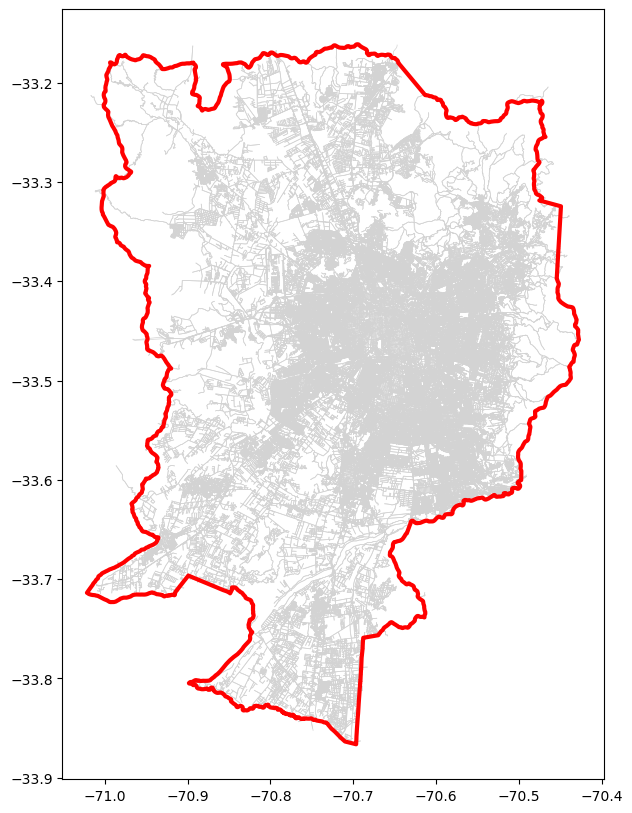

In [7]:
# Area of interest (aoi)
query = f"SELECT * FROM {aoi_schema}.{aoi_table} WHERE \"city\" LIKE \'{city}\'"
aoi = aup.gdf_from_query(query, geometry_col='geometry')
aoi = aoi.set_crs("EPSG:4326")

# OSMnx Network
G, nodes, edges = aup.graph_from_hippo(aoi, network_schema, edges_table, nodes_table, projected_crs)

# Show
fig,ax = plt.subplots(figsize=(10,10))
edges.plot(ax=ax,zorder=1,linewidth=0.5,edgecolor='lightgray')
aoi.plot(ax=ax,facecolor='None',edgecolor='red',linewidth=3)

In [8]:
# Format nodes (Geometry will be used, need osmid for merge)
nodes.reset_index(inplace=True)
nodes = nodes.to_crs("EPSG:4326")

# Show
print(nodes.shape)
nodes.head(2)

(257999, 5)


,osmid,x,y,street_count,geometry
0,386138,-70.646254,-33.442901,4,POINT (-70.64625 -33.44290)
1,386139,-70.647249,-33.443129,3,POINT (-70.64725 -33.44313)


## Polygons to nodes (pois)
#### Using voronoi distribution (and keeping data) [Based on Script 22-censo_pop_voronoi]

In [9]:
# 3.1 --------------- LOAD VORONOI POLYGONS(Created on Notebook 03c-polygon_to_pois_socialhousing)
# Load voronoi polygons
voronoi_schema = 'projects_research'
voronoi_table = 'santiago_voronoinodes'
query = f"SELECT * FROM {voronoi_schema}.{voronoi_table}"
voronois_gdf = aup.gdf_from_query(query, geometry_col='geometry')
voronois_gdf = voronois_gdf.set_crs("EPSG:4326")

# Format voronoi polygons
nodes_voronoi_gdf = voronois_gdf[['osmid','geometry']]

# Show
print(nodes_voronoi_gdf.shape)
nodes_voronoi_gdf.head(2)

(257949, 2)


,osmid,geometry
0,2570985396,"POLYGON ((-70.48877 -33.22815, -70.49911 -33.2..."
1,8421563147,"POLYGON ((-70.98379 -33.18318, -70.98594 -33.1..."


In [10]:
# 3.2 --------------- SPATIAL INTERSECTION OF POLYGONS WITH BLOCKS
print("--- Creating spatial join between voronoi polygons and blocks.")

# Calculate block area
mza_gdf = original_data.to_crs(projected_crs)
mza_gdf['area_mza'] = mza_gdf.geometry.area
mza_gdf = mza_gdf.to_crs("EPSG:4326")

# Overlay blocks with voronoi (Spatial intersection)
mza_voronoi = gpd.overlay(df1=mza_gdf, df2=nodes_voronoi_gdf, how="intersection")
del mza_gdf

aup.log("--- Calculating area_pct that corresponds to each osmid within each block.")

# Calculate pct of area that corresponds to each osmid within each block
mza_voronoi = mza_voronoi.to_crs(projected_crs)
mza_voronoi['area_voronoi'] = mza_voronoi.geometry.area
mza_voronoi = mza_voronoi.to_crs("EPSG:4326")
mza_voronoi['area_pct'] = mza_voronoi['area_voronoi']/mza_voronoi['area_mza']

# Drop used columns
mza_voronoi.drop(columns=['area_mza','area_voronoi'],inplace=True)

# Show
print(mza_voronoi.shape)
mza_voronoi.head(2)

--- Creating spatial join between voronoi polygons and blocks.
(480074, 4)


,Oficinas,osmid,geometry,area_pct
0,0.0,4442930597,"MULTIPOLYGON (((-70.74512 -33.38573, -70.74481...",0.001611
1,0.0,4442930354,"MULTIPOLYGON (((-70.74534 -33.38372, -70.74537...",0.000056


In [11]:
# 3.3 --------------- SUM DATA THAT CORRESPONDS TO EACH NODE (Groups mza_voronoi data by osmid)
print("--- Adding data by node.")

# Create pop_nodes_gdf (Will store nodes pop output by node)
data_nodes_gdf = nodes.copy()
data_nodes_gdf.drop(columns=['x','y','street_count'],inplace=True)

# For each column, sum data by osmid and assign to node
data_cols = columns_of_interest
data_cols.remove('geometry')
for col in data_cols:
    # Turn column to numeric
    mza_voronoi[col] = pd.to_numeric(mza_voronoi[col])
    # Calculate pop data proportionaly to pct that voronoi area is of block
    mza_voronoi[f'voronoi_{col}'] = mza_voronoi[col] * mza_voronoi['area_pct']
    # Group data by osmid
    osmid_grouped_data = mza_voronoi.groupby('osmid').agg({f'voronoi_{col}':np.sum})
    # Merge data to nodes_gdf
    osmid_grouped_data.reset_index(inplace=True)
    data_nodes_gdf = pd.merge(data_nodes_gdf, osmid_grouped_data, on='osmid')
    data_nodes_gdf.rename(columns={f'voronoi_{col}':col},inplace=True)

# Show
print(data_nodes_gdf.shape)
data_nodes_gdf.head(2)

--- Adding data by node.
(229965, 3)


,osmid,geometry,Oficinas
0,386139,POINT (-70.64725 -33.44313),12.820194
1,386140,POINT (-70.64767 -33.44304),0.008953


## Result comparison

In [12]:
# Not all data expeted to fall inside aoi since aoi clip could include blocks that fall outside aoi and are not voronoi distributed.
data_in_aoi = gpd.clip(original_data, aoi)

# Show
print("Result rough comparison (aprox.):")
print(data_in_aoi.Oficinas.sum())
print(data_nodes_gdf.Oficinas.sum())

Result rough comparison (aprox.):
81345.0
81287.49698173585


## Save

In [13]:
if save:
    data_nodes_gdf.to_file(f'../../../data/external/temporal_fromjupyter/santiago/pois/{save_name}', driver='GPKG')